<a href="https://colab.research.google.com/github/JSKimGitHub/real_time_driving_predictor/blob/main/EWC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python numpy matplotlib ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd

# CSV 파일 경로 지정 (구글 드라이브 마운트 경로 포함)
file_path = '/content/drive/MyDrive/labeling/towtruck_8_results.csv'
file_path2 = '/content/drive/MyDrive/labeling/Uturn_7_dlabeled.csv'
file_path3 = '/content/drive/MyDrive/labeling/driving_11_dlabeled.csv'  # 예시: 파일명이 '파일명.csv'인 경우

# CSV 파일을 DataFrame으로 읽어오기
truck8 = pd.read_csv(file_path)
uturn8 = pd.read_csv(file_path2)
driving11 = pd.read_csv(file_path3)


In [5]:
driving11_label=driving11['go_stop_decision']

In [6]:
from ultralytics import YOLO
import cv2
import numpy as np
import os

# YOLOv8 모델 로드
model = YOLO("yolov8n.pt")  # 가장 가벼운 모델

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
import torch
import torch.nn as nn

class FM_FTRL_Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim=8, k=4):
        super().__init__()
        self.linear = nn.Linear(input_dim, embedding_dim)
        self.V = nn.Parameter(torch.randn(input_dim, k) * 0.01)
        self.embedding_dim = embedding_dim

    def forward(self, x):
        linear_part = self.linear(x)
        fm_interactions = 0.5 * torch.sum(
            (x @ self.V) ** 2 - (x ** 2) @ (self.V ** 2),
            dim=1, keepdim=True
        )
        fm_interactions_expanded = fm_interactions.reshape(-1, 1).expand(-1, self.embedding_dim)
        return linear_part + fm_interactions_expanded

class FM_FTRL_WithClassifier(nn.Module):
    def __init__(self, input_dim, embedding_dim=8, k=4):
        super().__init__()
        self.encoder = FM_FTRL_Encoder(input_dim, embedding_dim, k)
        self.classifier = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        embedding = self.encoder(x)
        logits = self.classifier(embedding)
        return torch.sigmoid(logits).squeeze(1), embedding

class EWCWrapper:
    def __init__(self, model, lambda_ewc=1000.0):
        self.model = model
        self.lambda_ewc = lambda_ewc
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        self._fisher = {}

    def consolidate(self, dataloader, device):
        self._means = {n: p.clone().detach() for n, p in self.params.items()}
        fisher = {n: torch.zeros_like(p) for n, p in self.params.items()}

        self.model.eval()
        for x in dataloader:
            x = x.to(device)
            self.model.zero_grad()
            out, _ = self.model(x)
            loss = out.mean()
            loss.backward()

            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    fisher[n] += p.grad.data.clone().pow(2)

        for n in fisher:
            fisher[n] = fisher[n] / len(dataloader)
        self._fisher = fisher

    def penalty(self):
        loss = 0
        for n, p in self.model.named_parameters():
            if n in self._fisher:
                loss += (self._fisher[n] * (p - self._means[n]) ** 2).sum()
        return self.lambda_ewc * loss

In [8]:
import torch.optim as optim

In [9]:
# ===== 데이터 전처리 함수 =====
def preprocess_input(cls_id, conf, dist, area, cx, cy, num_classes=10):
    x = np.zeros(num_classes + 5)
    if 0 <= cls_id < num_classes:
        x[cls_id] = 1.0
    x[num_classes:] = [conf, dist / 100, area / 10000, cx / 1920, cy / 1080]
    return torch.tensor(x, dtype=torch.float32).unsqueeze(0)

def add_noise(x, level=0.1):
    return x + level * torch.randn_like(x)

In [10]:
# ===== 환경 설정 =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLO("yolov8n.pt")  # YOLOv8
input_dim = 10 + 5
fm_model = FM_FTRL_WithClassifier(input_dim)
optimizer = optim.Adam(fm_model.parameters(), lr=1e-3)
ewc = EWCWrapper(fm_model)

fm_model.to(device)
fm_model.train()
loss_fn = nn.MSELoss()

loss_buffer = []
action_buffer = []
measuring_loss = False
video_file_count = 0



# driving 11은 학습시킨 라벨로 돌림.


In [11]:
from google.colab import files
uploaded = files.upload()

# 업로드된 파일명 추출
video_path = next(iter(uploaded))

Saving driving_11.mp4 to driving_11.mp4


In [13]:
driving=driving11['go_stop_decision']

In [ ]:
# ===== 테스트용 비디오 불러오기 =====
#video_path = "/content/test_video.mp4"  # Colab에 업로드 후 경로 수정
cap = cv2.VideoCapture(video_path)

frame_idx = 0
step=0;
measuring_loss = True

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1

    result = model(frame)[0]
    h, w, _ = frame.shape
    frame_actions = []


    for box in result.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        area = (x2 - x1) * (y2 - y1)
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        est_dist = 700 * 1.7 / (y2 - y1 + 1e-6)

        x = preprocess_input(cls_id, conf, est_dist, area, cx, cy).to(device)
        x_noisy = add_noise(x)

        y_pred, emb_orig = fm_model(x)
        _, emb_noisy = fm_model(x_noisy)

        ewc_loss = ewc.penalty()

        label = torch.tensor([driving[frame_idx-1]], dtype=torch.float32).to(device)
        supervised_loss = loss_fn(y_pred, label)
        loss = supervised_loss + 0.1 * ewc_loss

        if measuring_loss:
          loss_buffer.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        act = int(y_pred.item() >= 0.5)
        frame_actions.append(act)

    final_act = 1 if frame_actions and sum(frame_actions) / len(frame_actions) >= 0.5 else 0
    if measuring_loss:
        action_buffer.append(final_act)


cap.release()

print("EWC Action Buffer:", action_buffer)
print("Loss Buffer:", loss_buffer)
print(frame_idx)

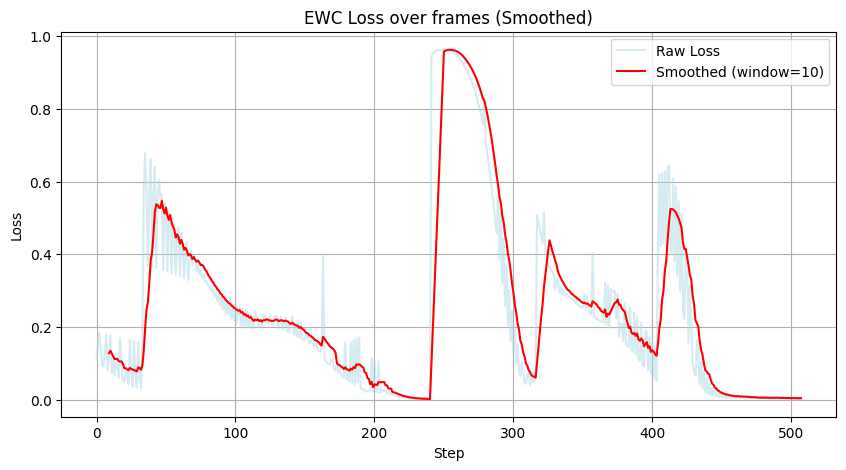

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 이동평균 함수
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 원본 데이터
plt.figure(figsize=(10, 5))
plt.plot(loss_buffer, color='lightblue', alpha=0.5, label='Raw Loss')

# 이동평균 데이터
smoothed_loss = moving_average(loss_buffer, 10)
plt.plot(range(10-1, len(loss_buffer)), smoothed_loss, color='red', label='Smoothed (window=10)')

plt.title("EWC Loss over frames (Smoothed)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

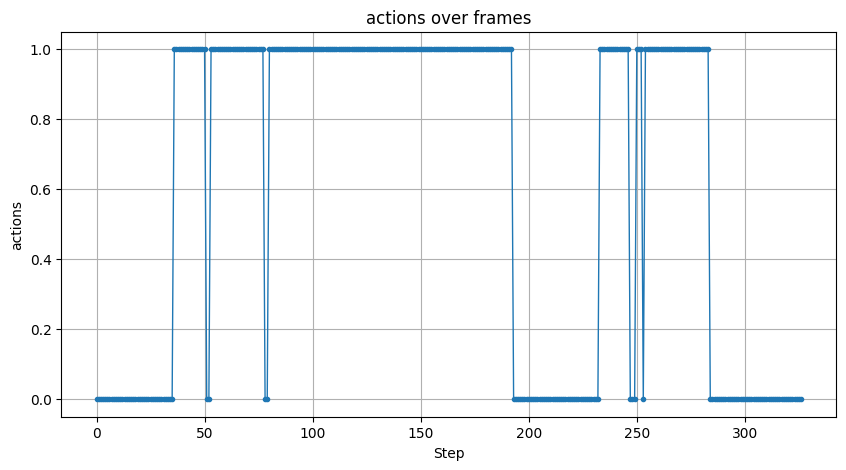

In [17]:
import matplotlib.pyplot as plt

# Loss 변화 시각화
plt.figure(figsize=(10, 5))
plt.plot(action_buffer, marker='o', markersize=3, linewidth=1)
plt.title("actions over frames")
plt.xlabel("Step")
plt.ylabel("actions")
plt.grid(True)
plt.show()

# 이후는 라벨 없이 돌림.

In [18]:
from google.colab import files
uploaded = files.upload()

# 업로드된 파일명 추출
video_path = next(iter(uploaded))

Saving driving_13.mp4 to driving_13.mp4


In [19]:
# ===== 테스트용 비디오 불러오기 =====
#video_path = "/content/test_video.mp4"  # Colab에 업로드 후 경로 수정
cap = cv2.VideoCapture(video_path)

frame_idx = 0
step=0;
measuring_loss = True
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1
    step += 1

    result = model(frame)[0]
    h, w, _ = frame.shape
    frame_actions = []


    for box in result.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        if conf <= 0.6:
              continue
        else:
          x1, y1, x2, y2 = map(int, box.xyxy[0])
          area = (x2 - x1) * (y2 - y1)
          cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
          est_dist = 700 * 1.7 / (y2 - y1 + 1e-6)

          x = preprocess_input(cls_id, conf, est_dist, area, cx, cy).to(device)
          x_noisy = add_noise(x)

          y_pred, emb_orig = fm_model(x)
          _, emb_noisy = fm_model(x_noisy)

          ewc_loss = ewc.penalty()

          loss = loss_fn(emb_noisy, emb_orig.detach())
          loss = loss + 0.1 * ewc_loss
          if measuring_loss:
              loss_buffer.append(loss.item())

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          act = int(y_pred.item() >= 0.5)
          frame_actions.append(act)

    final_act = 1 if frame_actions and sum(frame_actions) / len(frame_actions) >= 0.5 else 0
    if measuring_loss:
        action_buffer.append(final_act)

cap.release()

print("EWC Action Buffer:", action_buffer)
print("Loss Buffer:", loss_buffer)



0: 384x640 1 car, 1 truck, 183.0ms
Speed: 6.9ms preprocess, 183.0ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 truck, 151.0ms
Speed: 5.0ms preprocess, 151.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 truck, 168.5ms
Speed: 4.7ms preprocess, 168.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 truck, 334.7ms
Speed: 7.3ms preprocess, 334.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 truck, 287.4ms
Speed: 4.9ms preprocess, 287.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 637.7ms
Speed: 11.0ms preprocess, 637.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 truck, 393.4ms
Speed: 14.9ms preprocess, 393.4ms inference, 2.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 282.2ms
Speed: 5.4ms preprocess, 282.2ms inference

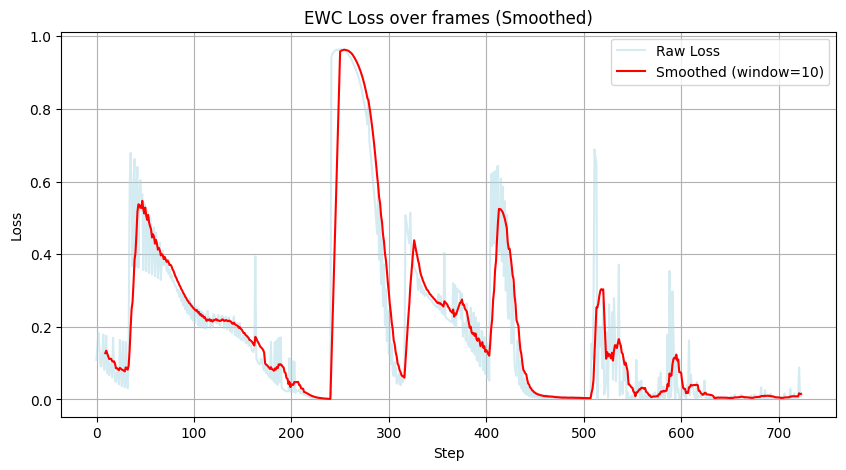

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# 이동평균 함수
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# 원본 데이터
plt.figure(figsize=(10, 5))
plt.plot(loss_buffer, color='lightblue', alpha=0.5, label='Raw Loss')

# 이동평균 데이터
smoothed_loss = moving_average(loss_buffer, 10)
plt.plot(range(10-1, len(loss_buffer)), smoothed_loss, color='red', label='Smoothed (window=10)')

plt.title("EWC Loss over frames (Smoothed)")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

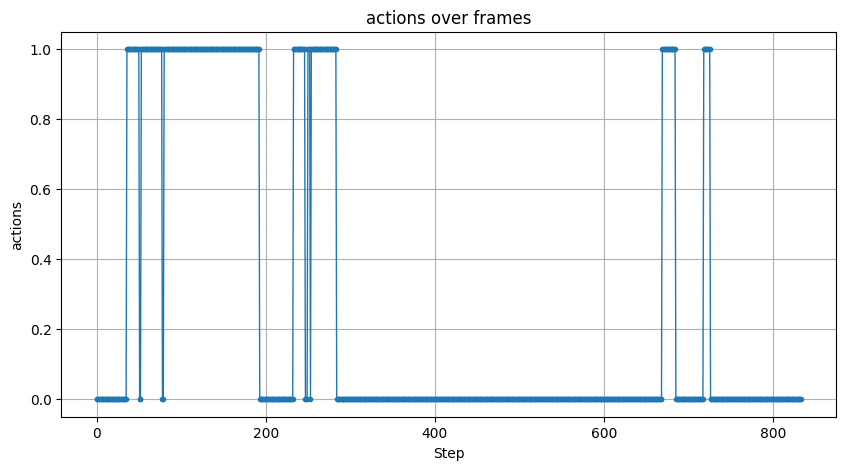

In [21]:
import matplotlib.pyplot as plt

# Loss 변화 시각화
plt.figure(figsize=(10, 5))
plt.plot(action_buffer, marker='o', markersize=3, linewidth=1)
plt.title("actions over frames")
plt.xlabel("Step")
plt.ylabel("actions")
plt.grid(True)
plt.show()

# 모델 평가하기

In [22]:
fm_model.eval()
loss_fn = nn.MSELoss()

test_loss_buffer = []
test_action_buffer = []
measuring_loss = False
test_video_file_count = 0

In [23]:
from google.colab import files
uploaded = files.upload()

# 업로드된 파일명 추출
test_video_path = next(iter(uploaded))

Saving towtruck_seperation_8.mov to towtruck_seperation_8.mov


In [ ]:
# ===== 테스트용 비디오 불러오기 =====
#video_path = "/content/test_video.mp4"  # Colab에 업로드 후 경로 수정
cap = cv2.VideoCapture(test_video_path)

frame_idx = 0
step=0;
measuring_loss = True
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_idx += 1
    step += 1
    # 예시: 100프레임마다 measuring_loss 시작

    result = model(frame)[0]
    h, w, _ = frame.shape
    frame_actions = []


    for box in result.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        area = (x2 - x1) * (y2 - y1)
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        est_dist = 700 * 1.7 / (y2 - y1 + 1e-6)

        x = preprocess_input(cls_id, conf, est_dist, area, cx, cy).to(device)
        x_noisy = add_noise(x)

        y_pred, emb_orig = fm_model(x)
        _, emb_noisy = fm_model(x_noisy)

        ewc_loss = ewc.penalty()

        loss = loss_fn(emb_noisy, emb_orig.detach())
        loss = loss + 0.1 * ewc_loss
        if measuring_loss:
            test_loss_buffer.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        act = int(y_pred.item() >= 0.5)
        frame_actions.append(act)

    final_act = 1 if frame_actions and sum(frame_actions) / len(frame_actions) >= 0.5 else 0
    if measuring_loss:
        test_action_buffer.append(final_act)

cap.release()






print("EWC Action Buffer:", test_action_buffer)
print("Loss Buffer:", test_loss_buffer)



0: 384x640 2 cars, 1 truck, 179.6ms
Speed: 7.0ms preprocess, 179.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 149.8ms
Speed: 9.0ms preprocess, 149.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 147.9ms
Speed: 9.3ms preprocess, 147.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 121.2ms
Speed: 5.6ms preprocess, 121.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 132.9ms
Speed: 3.8ms preprocess, 132.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 111.9ms
Speed: 3.7ms preprocess, 111.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 108.1ms
Speed: 3.8ms preprocess, 108.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 1 truck, 108.4ms
Speed: 3.8ms prepr

In [ ]:
test_frame_labels=truck8['go_stop_decision']

In [ ]:
test_frame_labels

,go_stop_decision
0,0
1,1
2,1
3,1
4,1
...,...
180,0
181,0
182,0
183,0


In [ ]:
import numpy as np

# --- test 종료 후 ---
# test_frame_labels : 실제 라벨 리스트 (길이 == frame 수)
# test_action_buffer : 예측 결과 리스트 (길이 == frame 수)

num_tasks = 10
test_frame_labels = np.array(test_frame_labels)  # 실제 라벨 (예: 0,1)
test_action_buffer = np.array(test_action_buffer)  # 예측 결과

# 태스크별 index 리스트 생성
task_indices = np.array_split(np.arange(len(test_action_buffer)), num_tasks)

In [ ]:
print(type(test_action_buffer), test_action_buffer.shape)
print(type(test_frame_labels), test_frame_labels.shape)

<class 'numpy.ndarray'> (185,)
<class 'numpy.ndarray'> (185,)


In [ ]:
# 태스크별 정확도 계산
task_accuracies = []
for idx in range(12):
    acc = np.mean(test_action_buffer[idx] == test_frame_labels[idx])
    task_accuracies.append(acc)
task_accuracies = np.array(task_accuracies)

# IM: 각 태스크 처음 배운 직후 정확도 (여기선 각 태스크 정확도 평균)
IM = np.mean(task_accuracies)

# FWT: baseline(0.5 랜덤 예측)을  기준으로 한 forward transfer (예시)
baseline_acc = 0.5
FWT = np.mean(task_accuracies[1:] - baseline_acc)

# BWT: 마지막 태스크 정확도 - 각 태스크 정확도의 평균 차이
BWT = np.mean(task_accuracies[-1] - task_accuracies[:-1])

print(f"IM (Initial Accuracy): {IM:.3f}")
print(f"FWT (Forward Transfer): {FWT:.3f}")
print(f"BWT (Backward Transfer): {BWT:.3f}")

IM (Initial Accuracy): 0.917
FWT (Forward Transfer): 0.500
BWT (Backward Transfer): 0.091


In [ ]:
num_tasks = 12
baseline_acc = 0.5

# 각 태스크 학습 직후 점수 저장
initial_task_accuracies = []
# 전체 학습이 끝난 뒤 점수 저장
final_task_accuracies = []

for task_idx in range(num_tasks):
    # ====== 학습 직후 테스트 ======
    preds_after_train = preds_after_each_task[task_idx]   # 이건 해당 태스크 학습 끝나자마자 예측값
    labels_after_train = labels_after_each_task[task_idx] # 그때의 정답
    acc_initial = np.mean(preds_after_train == labels_after_train)
    initial_task_accuracies.append(acc_initial)

    # ====== 전체 학습 끝난 후 테스트 ======
    preds_final = preds_after_all_tasks[task_idx]   # 마지막까지 다 배우고 난 뒤 예측값
    labels_final = labels_after_all_tasks[task_idx] # 그때의 정답
    acc_final = np.mean(preds_final == labels_final)
    final_task_accuracies.append(acc_final)

# numpy 배열 변환
initial_task_accuracies = np.array(initial_task_accuracies)
final_task_accuracies = np.array(final_task_accuracies)

# ====== 지표 계산 ======
IM = np.mean(initial_task_accuracies)  # 배우고 바로 점수
FWT = np.mean(initial_task_accuracies[1:] - baseline_acc)  # 전이 학습
BWT = np.mean(final_task_accuracies[:-1] - initial_task_accuracies[:-1])  # 얼마나 잊었나

print(f"IM (Initial Accuracy): {IM:.3f}")
print(f"FWT (Forward Transfer): {FWT:.3f}")
print(f"BWT (Backward Transfer): {BWT:.3f}")


NameError: name 'preds_after_each_task' is not defined

In [ ]:
count_ones = np.sum(test_action_buffer == 1)
print(count_ones)


185


In [ ]:
count_twos = np.sum(test_frame_labels == 0)
print(count_twos)

99


In [ ]:
import numpy as np

# 두 배열 길이 맞추기
min_len = min(len(test_action_buffer), len(test_frame_labels))
y_pred = test_action_buffer[:min_len]
y_true = test_frame_labels[:min_len]

# Accuracy 계산
accuracy = np.mean(y_pred == y_true)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4649
